In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt


In [ ]:
DATASET_PATH = "Levir-CD/"  # <--------------------------------------------------------------------this
TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A/A')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B/B')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/L/label')

VAL_IMG1_DIR = os.path.join(DATASET_PATH, 'val/A/A')
VAL_IMG2_DIR = os.path.join(DATASET_PATH, 'val/B/B')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val/L/label')

TEST_IMG1_DIR = os.path.join(DATASET_PATH, 'test/A/A')
TEST_IMG2_DIR = os.path.join(DATASET_PATH, 'test/B/B')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test/L/label')

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 8  # <--------------------------------------------------------------------------------this


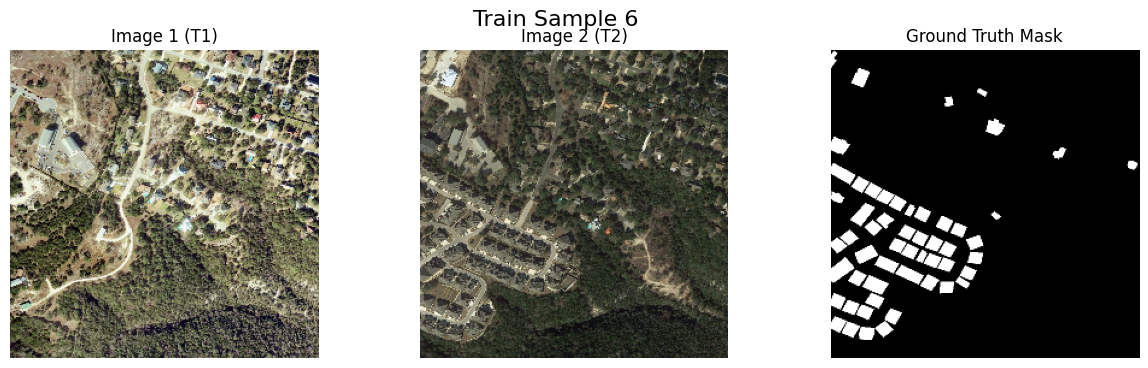

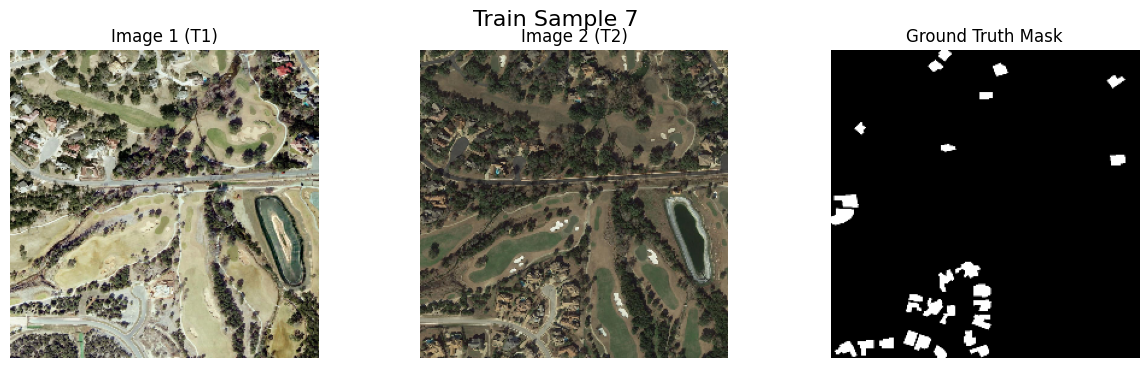

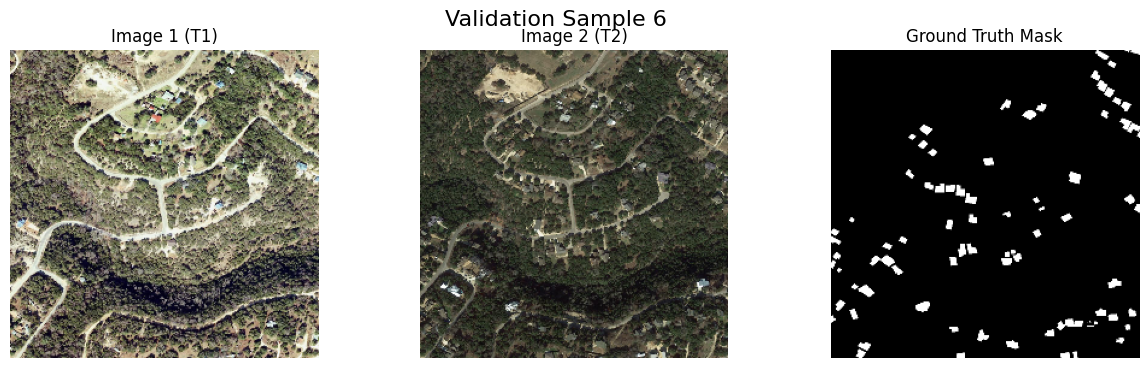

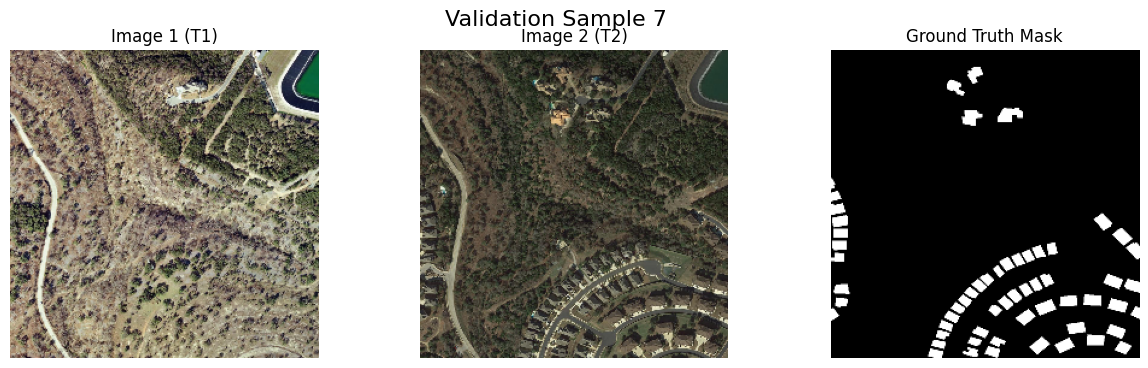

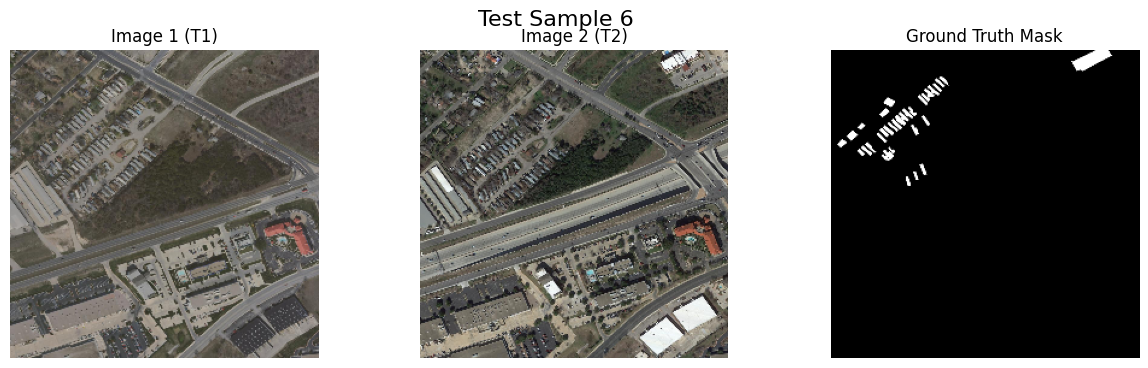

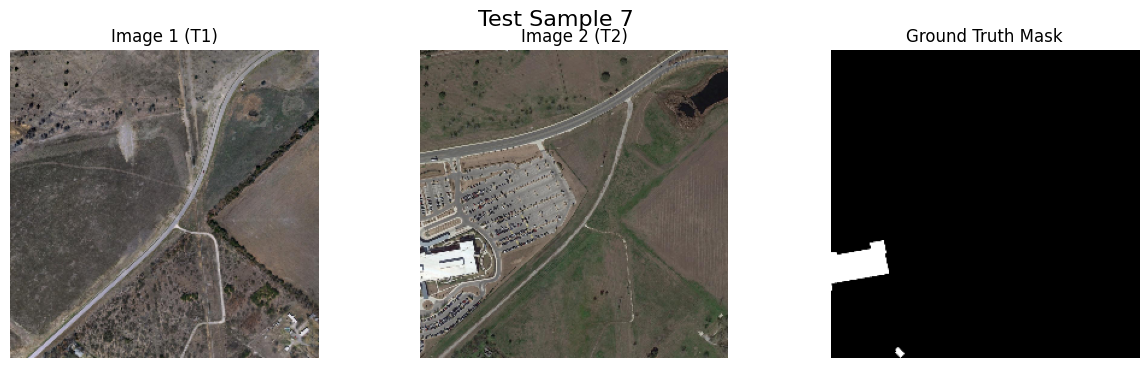

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample_pairs(img1_dir, img2_dir, mask_dir, title):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])

    for i in range(2):
        i+=5
        img1 = cv2.imread(img1_files[i])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

        img2 = cv2.imread(img2_files[i])
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

        mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"{title} Sample {i+1}", fontsize=16)

        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title("Image 1 (T1)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img2)
        plt.title("Image 2 (T2)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.show()

visualize_sample_pairs(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR, "Train")
visualize_sample_pairs(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR, "Validation")
visualize_sample_pairs(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR, "Test")


In [8]:
def get_file_lists(img1_dir, img2_dir, mask_dir):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    return img1_files, img2_files, mask_files

train_imgs1, train_imgs2, train_masks = get_file_lists(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR)
val_imgs1, val_imgs2, val_masks = get_file_lists(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR)
test_imgs1, test_imgs2, test_masks = get_file_lists(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_imgs1)} pairs")
print(f"Val  : {len(val_imgs1)} pairs")
print(f"Test : {len(test_imgs1)} pairs")


Train: 445 pairs
Val  : 64 pairs
Test : 128 pairs


In [9]:
def load_pair_numpy(img1_path, img2_path, mask_path):
    img1 = cv2.imread(img1_path.decode(), cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

    img2 = cv2.imread(img2_path.decode(), cv2.IMREAD_COLOR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

    img_pair = np.concatenate([img1, img2], axis=-1) / 255.0

    mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img_pair.astype(np.float32), mask

def load_pair_tf(img1_path, img2_path, mask_path):
    img_pair, mask = tf.numpy_function(load_pair_numpy, [img1_path, img2_path, mask_path], [tf.float32, tf.float32])
    img_pair.set_shape([IMG_SIZE, IMG_SIZE, 6])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return img_pair, mask

In [10]:
def create_dataset(img1_list, img2_list, mask_list, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((img1_list, img2_list, mask_list))
    ds = ds.map(load_pair_tf, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_imgs1, train_imgs2, train_masks, shuffle=True)
val_ds = create_dataset(val_imgs1, val_imgs2, val_masks)
test_ds = create_dataset(test_imgs1, test_imgs2, test_masks)


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_unit(x, filters, name=None):
    skip = layers.Conv2D(filters, 3, padding='same', name=f'{name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(skip)
    x = layers.Activation('selu', name=f'{name}_selu')(x)
    x = layers.Conv2D(filters, 3, padding='same', name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = layers.Add(name=f'{name}_add')([x, skip])
    return x

def UNetPP(input_shape=(IMG_SIZE, IMG_SIZE, 6), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    x00 = conv_unit(inputs, 32, name='x00')
    x10 = layers.MaxPooling2D(pool_size=(2, 2))(x00)
    x10 = conv_unit(x10, 64, name='x10')

    x20 = layers.MaxPooling2D(pool_size=(2, 2))(x10)
    x20 = conv_unit(x20, 128, name='x20')

    x30 = layers.MaxPooling2D(pool_size=(2, 2))(x20)
    x30 = conv_unit(x30, 256, name='x30')

    x40 = layers.MaxPooling2D(pool_size=(2, 2))(x30)
    x40 = conv_unit(x40, 512, name='x40')


    x01_up = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x10)
    x01 = layers.Concatenate()([x00, x01_up])
    x01 = conv_unit(x01, 32, name='x01')

    x11_up = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x20)
    x11 = layers.Concatenate()([x10, x11_up])
    x11 = conv_unit(x11, 64, name='x11')
    x21_up = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x30)
    x21 = layers.Concatenate()([x20, x21_up])
    x21 = conv_unit(x21, 128, name='x21')

    x31_up = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x40)
    x31 = layers.Concatenate()([x30, x31_up])
    x31 = conv_unit(x31, 256, name='x31')

    x02_up = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x11)
    x02 = layers.Concatenate()([x00, x01, x02_up])
    x02 = conv_unit(x02, 32, name='x02')

    x12_up = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x21)
    x12 = layers.Concatenate()([x10, x11, x12_up])
    x12 = conv_unit(x12, 64, name='x12')

    x03_up = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x12)
    x03 = layers.Concatenate()([x00, x01, x02, x03_up])
    x03 = conv_unit(x03, 32, name='x03')

    output = layers.Conv2D(num_classes, 1, activation='sigmoid')(x03)

    model = models.Model(inputs, output, name="UNetPlusPlus")
    return model

model = UNetPP()
model.summary()


Model: "UNetPlusPlus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
x00_conv1 (Conv2D)              (None, 256, 256, 32) 1760        input_2[0][0]                    
__________________________________________________________________________________________________
x00_bn1 (BatchNormalization)    (None, 256, 256, 32) 128         x00_conv1[0][0]                  
__________________________________________________________________________________________________
x00_selu (Activation)           (None, 256, 256, 32) 0           x00_bn1[0][0]                    
_______________________________________________________________________________________

In [39]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def precision_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    predicted_positives = tf.reduce_sum(y_pred_bin)
    precision = (true_positives + smooth) / (predicted_positives + smooth)
    return precision

def recall_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    actual_positives = tf.reduce_sum(y_true)
    recall = (true_positives + smooth) / (actual_positives + smooth)
    return recall

def f1_metric(y_true, y_pred, smooth=1e-6):
    prec = precision_metric(y_true, y_pred, smooth)
    rec = recall_metric(y_true, y_pred, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        iou_metric,
        precision_metric,
        recall_metric,
        f1_metric
    ]
)

print("done")

done


In [40]:
# import os
# name= os.path.basename(__file__)
# print(name)


Epoch 1/50
56/56 [==============================] - 37s 603ms/step - loss: 0.3665 - accuracy: 0.9778 - iou_metric: 0.5985 - precision_metric: 0.7756 - recall_metric: 0.7385 - f1_metric: 0.7447 - val_loss: 0.4383 - val_accuracy: 0.9740 - val_iou_metric: 0.5332 - val_precision_metric: 0.6938 - val_recall_metric: 0.7013 - val_f1_metric: 0.6930

Epoch 00001: val_f1_metric improved from -inf to 0.69301, saving model to 04_U_net++.h5
Epoch 2/50
56/56 [==============================] - 34s 602ms/step - loss: 0.3447 - accuracy: 0.9786 - iou_metric: 0.6172 - precision_metric: 0.7790 - recall_metric: 0.7550 - f1_metric: 0.7616 - val_loss: 0.3794 - val_accuracy: 0.9782 - val_iou_metric: 0.5767 - val_precision_metric: 0.7883 - val_recall_metric: 0.6856 - val_f1_metric: 0.7296

Epoch 00002: val_f1_metric improved from 0.69301 to 0.72964, saving model to 04_U_net++.h5
Epoch 3/50
56/56 [==============================] - 36s 627ms/step - loss: 0.3458 - accuracy: 0.9791 - iou_metric: 0.6163 - precision

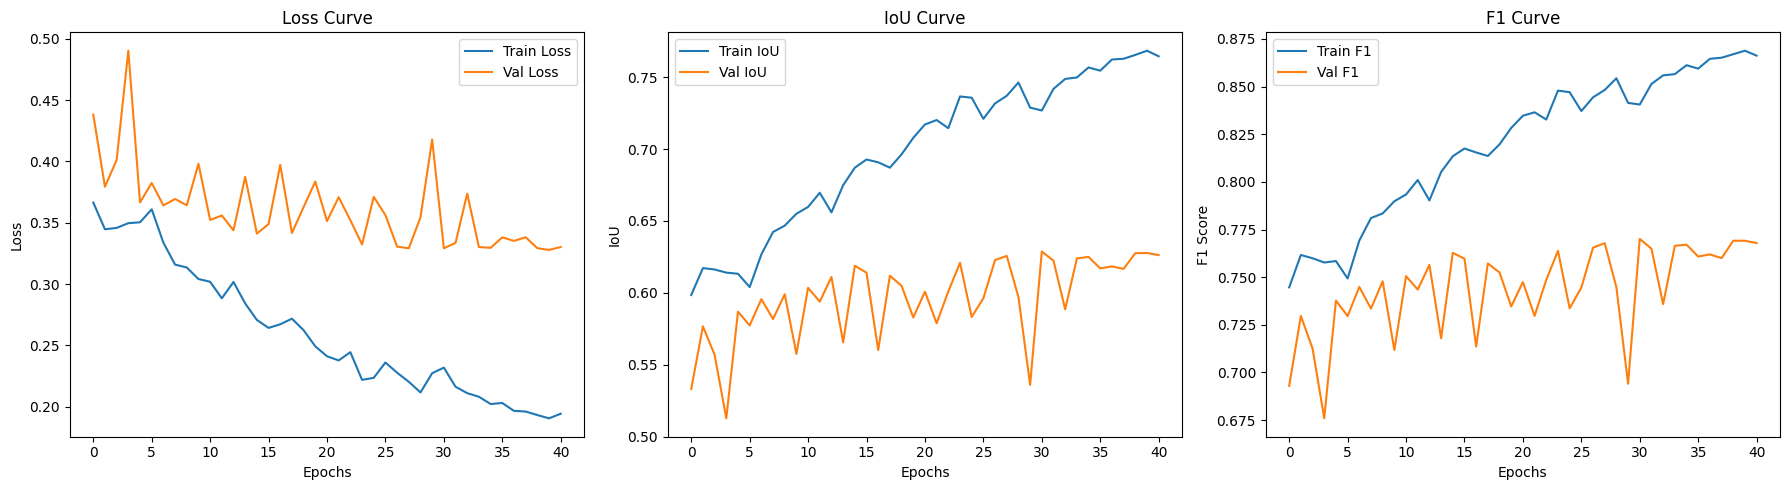

Training complete


In [41]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    '04_U_net++.h5',
    monitor='val_f1_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_metric',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['f1_metric'], label='Train F1')
plt.plot(history.history['val_f1_metric'], label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete")

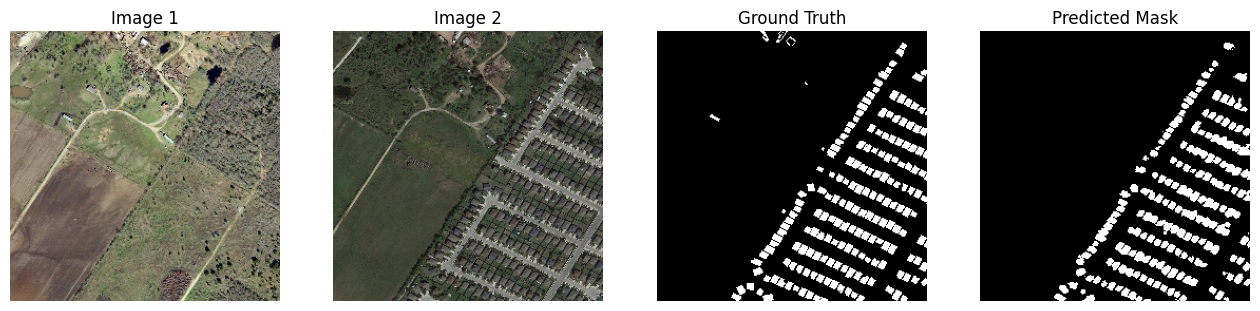

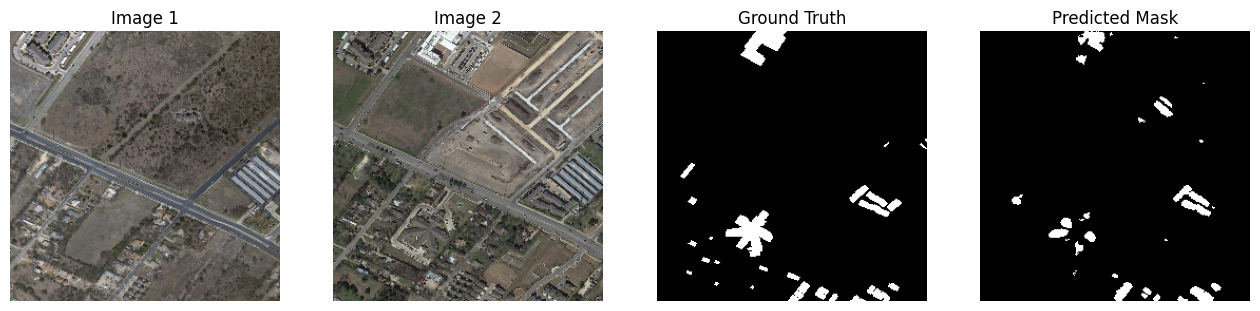

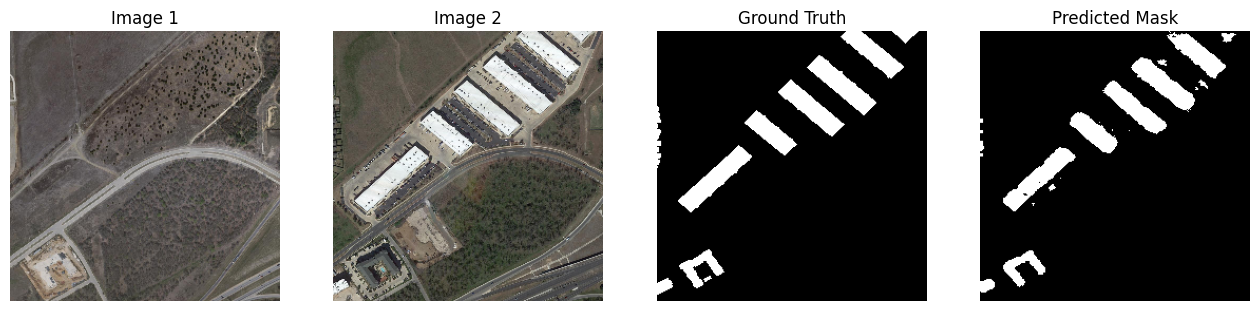

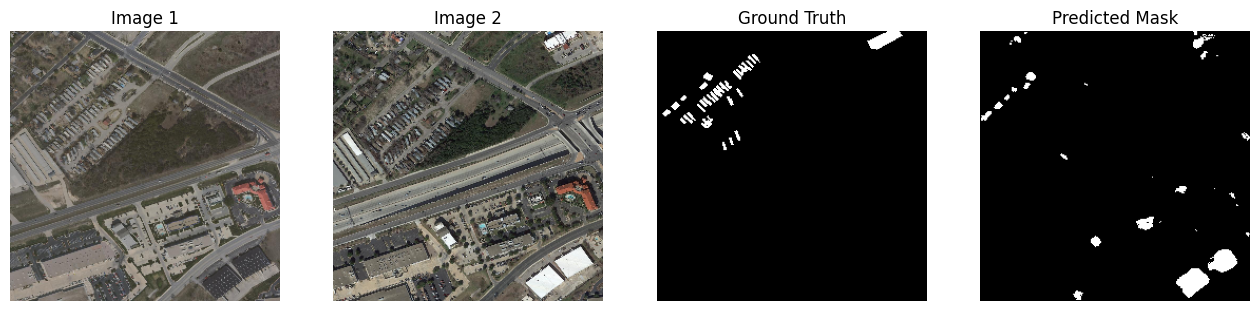

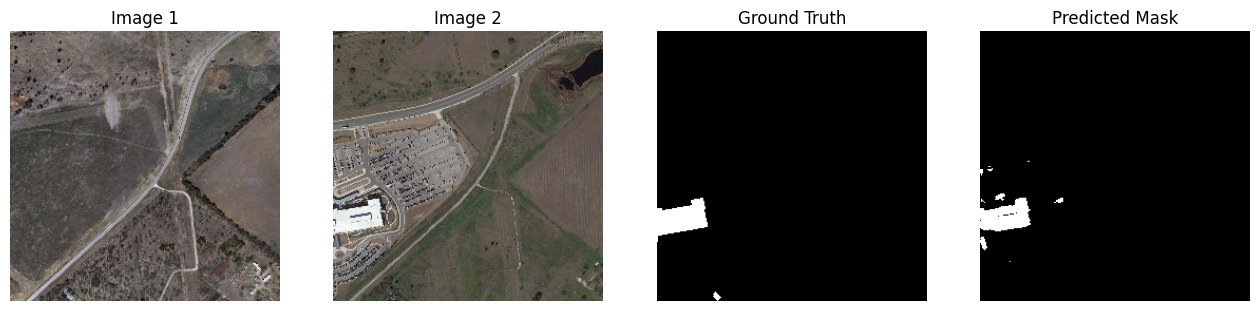

In [42]:
def visualize_predictions_grid(dataset, num_samples=5):
    import matplotlib.pyplot as plt
    import tensorflow as tf

    for imgs, masks in dataset.take(1):
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        num_samples_to_show = min(num_samples, tf.shape(imgs)[0])

        for i in range(num_samples_to_show):
            i=i+2
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 4, 1)
            plt.imshow(tf.cast(imgs[i][:, :, :3], tf.float32), vmin=0, vmax=1)
            plt.title("Image 1")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(tf.cast(imgs[i][:, :, 3:6], tf.float32), vmin=0, vmax=1)
            plt.title("Image 2")
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions_grid(test_ds, num_samples=5)

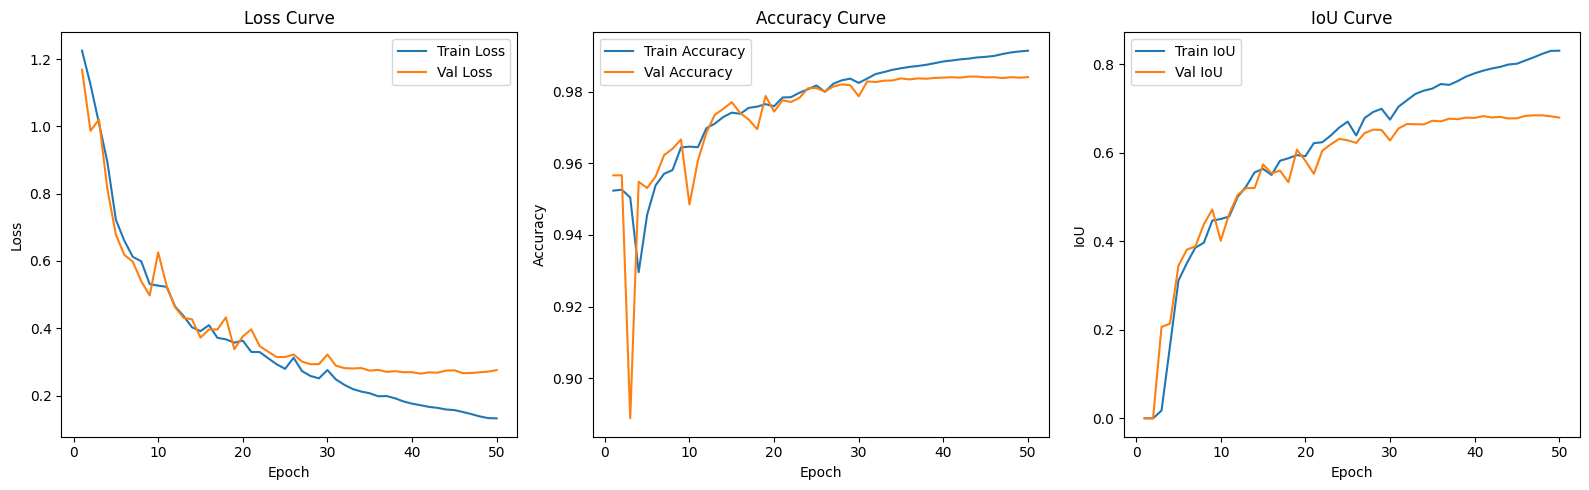

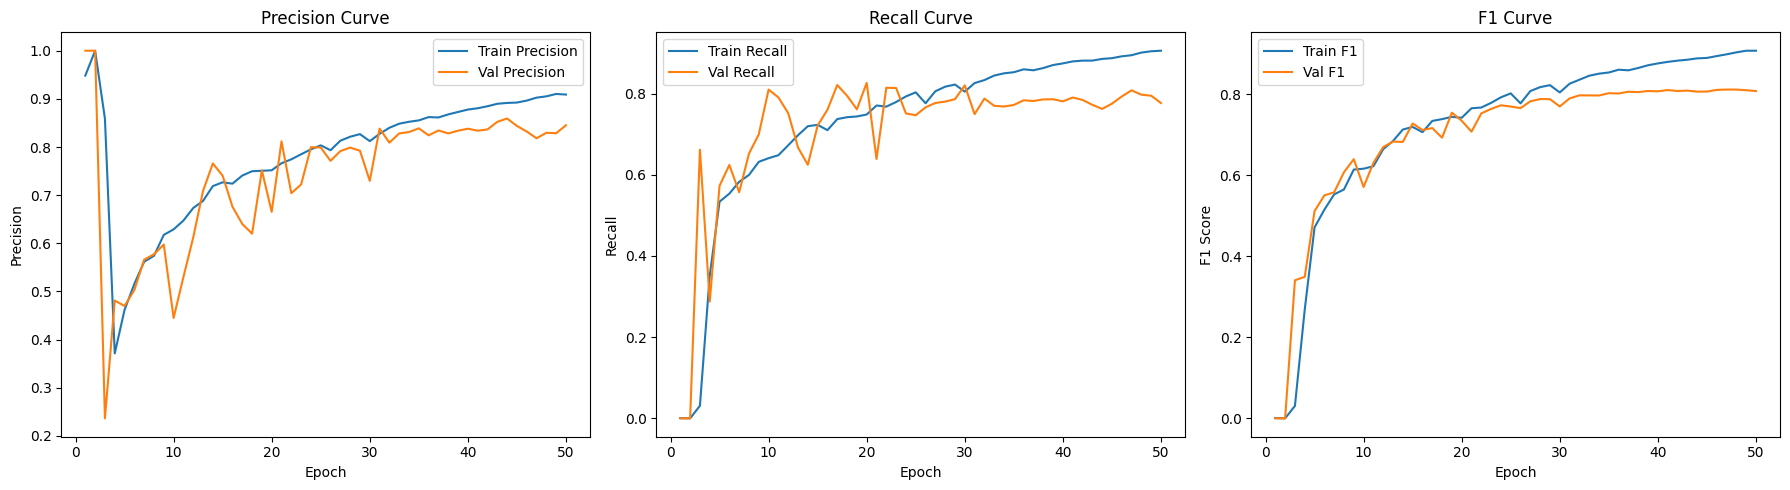

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Train IoU')
plt.plot(epochs, val_iou, label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.title('Precision Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.title('Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, f1, label='Train F1')
plt.plot(epochs, val_f1, label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)
print(" Final Training Metrics:")

print(f" Final Train Loss: {loss[-1]:.4f}")
print(f" Final Val Loss  : {val_loss[-1]:.4f}\n")

print(f" Final Train Accuracy: {accuracy[-1]:.4f}")
print(f" Final Val Accuracy  : {val_accuracy[-1]:.4f}\n")

print(f" Final Train IoU: {iou[-1]:.4f}")
print(f" Final Val IoU  : {val_iou[-1]:.4f}\n")

print(f" Final Train Precision: {precision[-1]:.4f}")
print(f" Final Val Precision  : {val_precision[-1]:.4f}\n")

print(f" Final Train Recall: {recall[-1]:.4f}")
print(f" Final Val Recall  : {val_recall[-1]:.4f}\n")

print(f" Final Train F1 Score: {f1[-1]:.4f}")
print(f" Final Val F1 Score  : {val_f1[-1]:.4f}")



 Final Training Metrics:
 Final Train Loss: 0.1943
 Final Val Loss  : 0.3302

 Final Train Accuracy: 0.9877
 Final Val Accuracy  : 0.9811

 Final Train IoU: 0.7645
 Final Val IoU  : 0.6263

 Final Train Precision: 0.8747
 Final Val Precision  : 0.8140

 Final Train Recall: 0.8603
 Final Val Recall  : 0.7311

 Final Train F1 Score: 0.8662
 Final Val F1 Score  : 0.7679


In [44]:
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import cohen_kappa_score, jaccard_score

def evaluate_model_metrics(model, dataset, num_samples=100):
    y_trues = []
    y_preds = []

    # Timing: Inference
    total_pred_time = 0
    count = 0

    for (batch, mask_batch) in dataset.take(num_samples):
        # Handle Siamese or FC-EF
        if isinstance(batch, tuple):
            input_data = [batch[0], batch[1]]
        else:
            input_data = batch

        start = time.time()
        preds = model.predict(input_data)
        total_pred_time += time.time() - start

        preds_bin = (preds > 0.5).astype(np.uint8)
        y_trues.append(mask_batch.numpy().flatten())
        y_preds.append(preds_bin.flatten())

        count += 1

    y_trues = np.concatenate(y_trues)
    y_preds = np.concatenate(y_preds)

    precision = np.sum((y_preds == 1) & (y_trues == 1)) / (np.sum(y_preds == 1) + 1e-6)
    recall = np.sum((y_preds == 1) & (y_trues == 1)) / (np.sum(y_trues == 1) + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    kappa = cohen_kappa_score(y_trues, y_preds)
    jaccard = jaccard_score(y_trues, y_preds)
    accuracy = np.sum(y_trues == y_preds) / len(y_trues)

    param_count = model.count_params()

    try:
        concrete_func = tf.function(model).get_concrete_function(
            [tf.TensorSpec([1] + list(inp.shape[1:]), inp.dtype) for inp in model.inputs]
        )
        frozen_func, graph_def = tf.compat.v1.graph_util.convert_variables_to_constants_v2_as_graph(concrete_func)
        flops = tf.compat.v1.profiler.profile(
            graph=frozen_func.graph,
            options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        ).total_float_ops
    except:
        flops = "Unavailable in this environment"

    try:
        epoch_times = history.history.get('epoch_times', None)
        if epoch_times:
            avg_epoch_time = np.mean(epoch_times)
        else:
            avg_epoch_time = "Not tracked"
    except:
        avg_epoch_time = "Not tracked"

    avg_pred_time = total_pred_time / count

    print(" Evaluation Metrics on Test Set:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Cohen's Kappa: {kappa:.4f}")
    print(f" Jaccard Index (IoU): {jaccard:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Parameter Count: {param_count:,}")
    print(f" FLOPs: {flops if isinstance(flops, str) else f'{flops:,}'}")
    print(f" Avg Training Time per Epoch: {avg_epoch_time} seconds")
    print(f" Avg Prediction Time per Image: {avg_pred_time:.4f} seconds")

evaluate_model_metrics(model, test_ds, num_samples=20)


 Evaluation Metrics on Test Set:
 Precision: 0.8128
 Recall: 0.7398
 F1 Score: 0.7746
 Cohen's Kappa: 0.7627
 Jaccard Index (IoU): 0.6321
 Accuracy: 0.9774
 Parameter Count: 2,213,057
 FLOPs: Unavailable in this environment
 Avg Training Time per Epoch: Not tracked seconds
 Avg Prediction Time per Image: 0.2329 seconds
